# Forecasting Average Supplier Submitted Charges Using ARIMA and Prophet

## Introduction

This notebook examines temporal patterns in **average supplier submitted charges**, focusing on regional trends and cost variations. By forecasting future charges, the analysis provides insights into cost trajectories and highlights regions with potential inefficiencies.

The analysis employs **ARIMA** and **Prophet models** to predict future trends, enabling policymakers to monitor and manage rising costs effectively.


## Models Used

### 1. ARIMA (AutoRegressive Integrated Moving Average)
- **Objective**: Detect linear trends and autoregressive dependencies in submitted charges.
- **Strengths**: Suitable for datasets with consistent patterns over time.
- **Tuning**:
  - Optimal (p, d, q) values chosen based on AIC and BIC scores.
  - Iterative parameter testing ensured model accuracy.

### 2. Prophet
- **Objective**: Model complex non-linear trends and seasonality in submitted charges.
- **Strengths**: Effective for handling missing data and abrupt changes in trends.
- **Configuration**:
  - Seasonal components included to capture charge fluctuations.
  - Trend changepoints enabled for better prediction accuracy.


## Methodology

### Data Preprocessing
- Cleaned data to remove anomalies using Isolation Forest and Local Outlier Factor (LOF).
- Reformatted for ARIMA and Prophet modeling (`ds` for dates and `y` for submitted charges).

### Model Evaluation
- TimeSeriesSplit cross-validation applied to validate the models.
- Forecasting conducted for the next 5 years to identify future cost trends.

## Research Question
**RQ4**: How have supplier charges varied by region over time, and how can these temporal trends help optimize costs?

## Outputs

### Forecast Visualizations
- Observed vs. forecasted average charges for ARIMA and Prophet models.
- Regional disparities in predicted charges highlighted using visual overlays.

### Exported Predictions
- Average charge forecasts saved for the top regions for the next 5 years.
- Confidence intervals included for Prophet predictions.


## Implications

- Rising charges in specific regions necessitate cost management interventions.
- Temporal patterns inform future policy adjustments to mitigate cost escalation.
- Combining Prophet and ARIMA ensures robust predictions for better regional planning.



In [1]:
# Set the working directory to the folder 
import os
os.chdir('/Users/rozani/Desktop/capstone')


In [26]:
#filter warnings
import warnings
warnings.filterwarnings("ignore")

# Import required modules
import numpy as np
import pandas as pd


from pmdarima.arima import auto_arima
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt

#!pip install prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

In [28]:
# Load data
# data is loaded from a CSV file and parsed by the Year column
data = pd.read_csv('cleaned_data.csv', parse_dates=['Year'], index_col='Year')
test_data = pd.read_csv('test_data.csv', parse_dates=['Year'], index_col='Year')

# Combine training and test data by appending rows
combined_data = pd.concat([data, test_data])


## Analysis of Average Supplier Submitted Charges Over Time

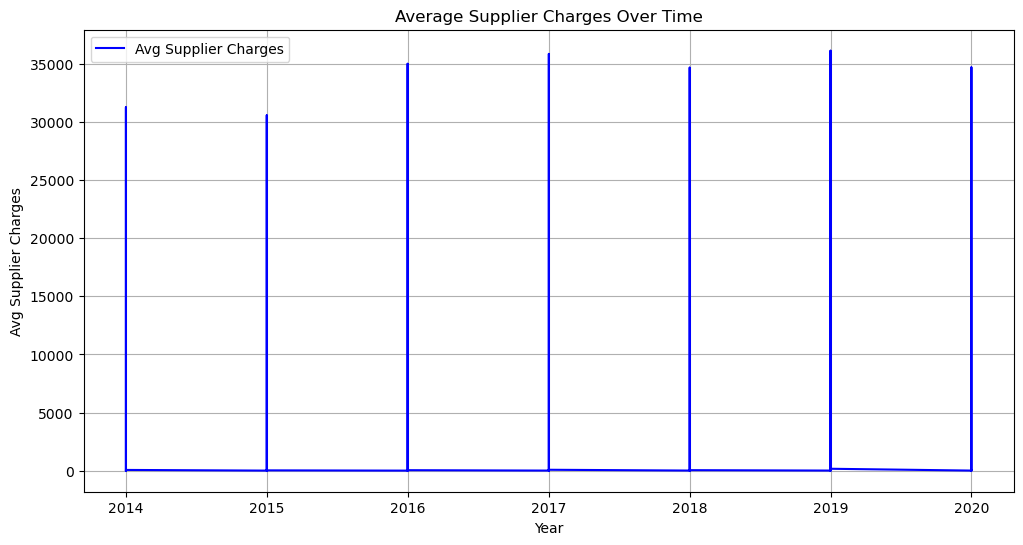

In [4]:
# Plotting Average Supplier Charges Over Time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Avg_Suplr_Sbmtd_Chrg'], label='Avg Supplier Charges', color='blue')
plt.xlabel('Year')
plt.ylabel('Avg Supplier Charges')
plt.title('Average Supplier Charges Over Time')
plt.grid(True)
plt.legend()
plt.show()



[]

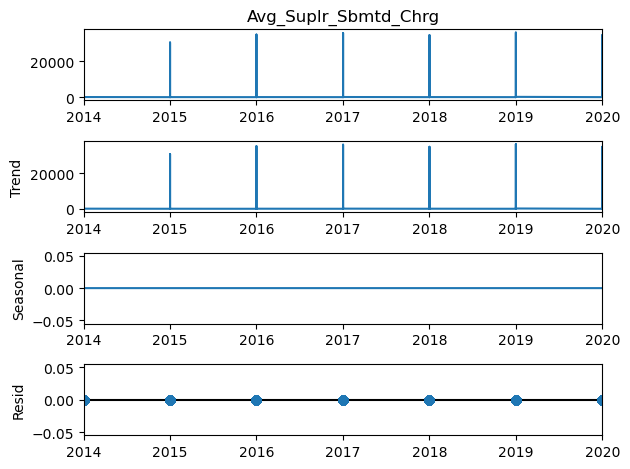

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['Avg_Suplr_Sbmtd_Chrg'], model='additive', period=1)
result.plot()
plt.plot()

## Analysis of Line plot and Decomposition Graph

### Line Plot Observations

- Clear spikes in supplier charges during specific years (2015, 2017, 2019) dominate the pattern.
- These anomalies warrant further investigation to determine their causes (e.g., policy changes, supplier behavior).


### Decomposition Results

1. **Trend Component**:
   - Significant spikes in supplier charges occurred during 2015, 2017, and 2019.
   - No consistent upward or downward trend was observed, suggesting charges are more influenced by external factors than by inherent seasonality.

2. **Seasonal Component**:
   - Negligible seasonal variations, with values oscillating close to zero.
   - Indicates no systematic seasonal effects on supplier charges.

3. **Residual Component**:
   - Residuals are minimal and consistent, highlighting a well-fitted decomposition model.




## Hypothesis for ADF Test

The Augmented Dickey-Fuller (ADF) test is used to determine whether a time series is stationary or contains a unit root (non-stationary). The hypotheses for the ADF test are:

- **Null Hypothesis (H₀)**: The series has a unit root, meaning it is *non-stationary*.
- **Alternative Hypothesis (H₁)**: The series is *stationary* (i.e., it does not have a unit root).

The p-value obtained from the ADF test will help us determine whether to reject the null hypothesis.



In [6]:
from statsmodels.tsa.stattools import adfuller

# Create a subset for the ADF test using data from the last 3 years
data_subset = data['Avg_Suplr_Sbmtd_Chrg']['2018':'2020']

# Run the ADF test on this subset
adf_result = adfuller(data_subset)
print("ADF Test p-value:", adf_result[1])

ADF Test p-value: 0.0


### Results 

The p-value obtained from the Augmented Dickey-Fuller (ADF) test is 0.0, which is much smaller than the commonly used significance level of 0.05. As a result, we reject the null hypothesis and conclude that the time series is stationary


## Hypothesis for KPSS Test
- **Null Hypothesis (H₀)**: The series is stationary (trend-stationary).
- **Alternative Hypothesis (H₁)**: The series has a unit root and is non-stationary.


In [29]:
from statsmodels.tsa.stattools import kpss

kpss_result = kpss(data['Avg_Suplr_Sbmtd_Chrg'])
print(kpss_result[1])

0.1


### Results 
Since the p-value is greater than 0.05, we fail to reject the null hypothesis and conclude that the time series is stationary.

## Hypothesis for Phillips-Perron (PP) Test

The Phillips-Perron (PP) test is used to determine the stationarity of a time series by testing for a unit root. The hypotheses for the PP test are:

- **Null Hypothesis (H₀)**: The series has a unit root, meaning it is *non-stationary*.
- **Alternative Hypothesis (H₁)**: The series is *stationary* (i.e., it does not have a unit root).


In [8]:
from arch import unitroot

pp_test = unitroot.PhillipsPerron(data['Avg_Suplr_Sbmtd_Chrg'])
print(pp_test)

     Phillips-Perron Test (Z-tau)    
Test Statistic               -110.851
P-value                         0.000
Lags                               88
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# Phillips-Perron Test Results for Stationarity

## Test Summary

- **Test Statistic**: -110.851
- **P-value**: 0.000
- **Lags Used**: 88
- **Critical Values**:
  - 1%: -3.43
  - 5%: -2.86
  - 10%: -2.57


## Interpretation

1. **Null Hypothesis**:
   - The time series contains a unit root (non-stationary).
2. **Alternative Hypothesis**:
   - The time series is weakly stationary.
3. **Results**:
   - The test statistic is far smaller than the critical values at all levels.
   - The p-value (0.000) is below the significance threshold (e.g., 0.05).
4. **Conclusion**:
   - The null hypothesis is rejected. The data **does not contain a unit root**, indicating that it is **stationary**.



# Plot auto-correlations

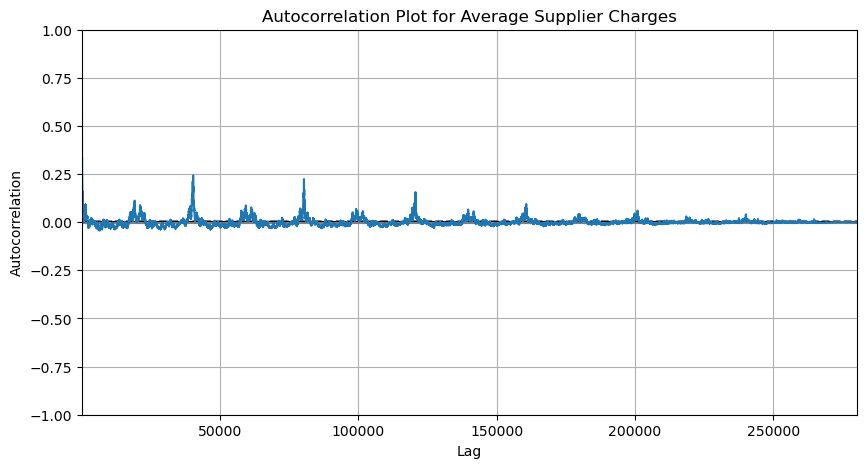

In [9]:
from pandas.plotting import autocorrelation_plot


# Plot the autocorrelation 
plt.figure(figsize=(10, 5))
autocorrelation_plot(data['Avg_Suplr_Sbmtd_Chrg'])
plt.title('Autocorrelation Plot for Average Supplier Charges')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()


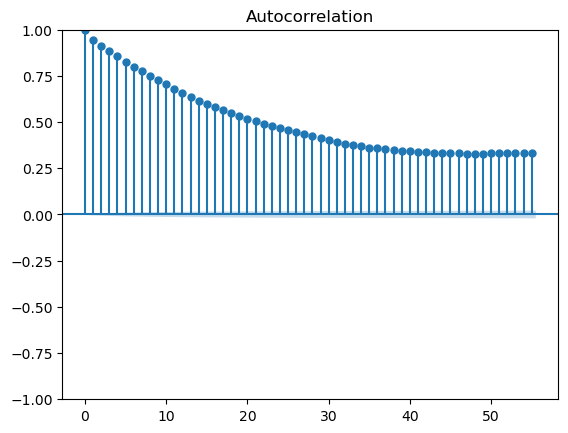

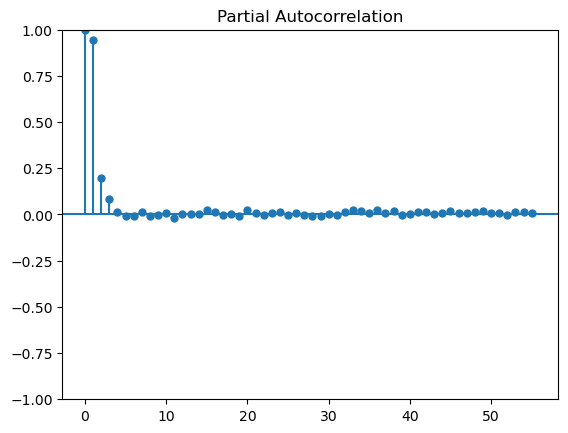

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(data['Avg_Suplr_Sbmtd_Chrg'])
plt.show()

plot_pacf(data['Avg_Suplr_Sbmtd_Chrg'])
plt.show()


### Analysis Summary

- The autocorrelation plot shows periodic peaks, suggesting **seasonality** or cyclic behavior in supplier charges. 
- The ACF gradually decays, indicating **non-stationarity**, while the PACF cuts off after a few lags, suggesting a low AR order. 


# Auto-fit the ARIMA model using 2014 & 2015 data to find the best order

In [11]:
# Filter data using the datetime index for 2014 and 2015
train_series = data.loc['2014', 'Avg_Suplr_Sbmtd_Chrg']
test_series= data.loc['2015', 'Avg_Suplr_Sbmtd_Chrg']

# Use auto_arima to find the best ARIMA model
auto_model = pm.auto_arima(
    train_series,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,            # Let auto_arima determine the optimal 'd' value
    seasonal=False,    
    trace=True,        # Print output for each fit
    error_action='ignore',   # Ignore non-converging models
    suppress_warnings=True,  # Suppress warnings
    stepwise=True           # Use stepwise search to reduce computation time
)

# Print the best model's summary
print("Best model summary:")
print(auto_model.summary())

# Access the best ARIMA model's parameters
print(f"Best ARIMA model order: {auto_model.order}")
print(f"Best AIC: {auto_model.aic()}")


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=610562.843, Time=0.88 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=608641.827, Time=1.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=608565.251, Time=2.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=610560.843, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=608566.587, Time=4.63 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=608566.634, Time=2.82 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=608568.421, Time=4.96 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=608563.251, Time=1.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=608564.587, Time=2.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=608564.634, Time=1.68 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=608639.827, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=608566.421, Time=2.82 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 28.283 seconds
Best model summary:
                               SARIMAX Resu

# Train and Test the ARIMA model with best order

In [30]:
# Select the 'Tot_Suplr_Srvcs' column
train_series = data['Avg_Suplr_Sbmtd_Chrg']
test_series = test_data['Avg_Suplr_Sbmtd_Chrg']

# Initialize TimeSeriesSplit for ARIMA
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists for metrics
rmse_scores, mae_scores, mslp_scores = [], [], []

# Cross-validation for ARIMA
for train_index, test_index in tscv.split(train_series):
    train_fold, test_fold = train_series.iloc[train_index], train_series.iloc[test_index]
    
    # Fit ARIMA model
    model = ARIMA(train_fold, order=(0, 1, 1))
    fitted_model = model.fit()
    
    # Forecast and evaluate
    predictions = fitted_model.forecast(steps=len(test_fold))
    y_true, y_pred = test_fold.values, predictions.values

    # Calculate RMSE
    rmse_scores.append(np.sqrt(mean_squared_error(y_true, y_pred)))

    # Calculate MAE
    mae_scores.append(mean_absolute_error(y_true, y_pred))

    # Calculate MSLP
    mslp = np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2))
    mslp_scores.append(mslp)

# Calculate average metrics across cross-validation folds
avg_rmse = np.mean(rmse_scores)
avg_mae = np.mean(mae_scores)
avg_mslp = np.mean(mslp_scores)

print("Cross-Validation Metrics:")
print(f"Average RMSE: {avg_rmse:.2f}")
print(f"Average MAE: {avg_mae:.2f}")
print(f"Average MSLP: {avg_mslp:.2f}")

# Fit ARIMA on the entire training dataset
final_model = ARIMA(train_series, order=(0, 1, 1))
final_fitted_model = final_model.fit()

# Test dataset predictions
test_predictions = final_fitted_model.forecast(steps=len(test_series))

# Evaluate on test dataset
y_true_test, y_pred_test = test_series.values, test_predictions.values
test_rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
test_mae = mean_absolute_error(y_true_test, y_pred_test)
test_mslp = np.sqrt(np.mean((np.log1p(y_true_test) - np.log1p(y_pred_test)) ** 2))

print("\nTest Dataset Results:")
print(f"RMSE: {test_rmse:.2f}")
print(f"MAE: {test_mae:.2f}")
print(f"MSLP: {test_mslp:.2f}")

# Print final model summary
print("\nFinal ARIMA Model Summary:")
print(final_fitted_model.summary())



Cross-Validation Metrics:
Average RMSE: 1718.82
Average MAE: 534.26
Average MSLP: 2.54

Test Dataset Results:
RMSE: 2211.22
MAE: 614.74
MSLP: 2.15

Final ARIMA Model Summary:
                                SARIMAX Results                                 
Dep. Variable:     Avg_Suplr_Sbmtd_Chrg   No. Observations:               280299
Model:                   ARIMA(0, 1, 1)   Log Likelihood            -2158157.697
Date:                  Wed, 20 Nov 2024   AIC                        4316319.395
Time:                          23:10:19   BIC                        4316340.482
Sample:                               0   HQIC                       4316325.511
                               - 280299                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.26

# Cross-Validation and Test Metrics Analysis

## Metric Definitions

### 1. Root Mean Square Error (RMSE)
\[
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}
\]
- Measures the average magnitude of errors, penalizing larger deviations more heavily.

---

### 2. Mean Absolute Error (MAE)
\[
MAE = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|
\]
- Represents the average of absolute errors, offering a straightforward measure of prediction accuracy.

---

### 3. Mean Squared Logarithmic Percentage (MSLP)
\[
MSLP = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\log(y_i + 1) - \log(\hat{y}_i + 1)\right)^2}
\]
- Penalizes large relative deviations, useful for datasets with multiplicative effects.

---

## Comparison of Cross-Validation and Test Metrics

| **Metric**            | **Cross-Validation (Average)** | **Test Dataset Results** | **Insights**                                                                 |
|------------------------|--------------------------------|---------------------------|-------------------------------------------------------------------------------|
| **RMSE**              | 1718.82                       | 2211.22                  | Test RMSE is higher, indicating challenges in generalizing to unseen data.   |
| **MAE**               | 534.26                        | 614.74                   | Moderate increase, showing relatively consistent prediction accuracy.        |
| **MSLP**              | 2.54                          | 2.15                     | Lower test MSLP suggests better handling of relative errors in unseen data.  |

---

## Final ARIMA Model Summary

- **Model**: ARIMA(0, 1, 1)
- **Log Likelihood**: -2,158,157.697
- **AIC**: 4,316,319.395
- **BIC**: 4,316,340.482

### Key Parameters:
| **Parameter** | **Coefficient** | **Std. Error** | **z-Statistic** | **P-Value** | **Confidence Interval (95%)** |
|---------------|-----------------|----------------|-----------------|-------------|------------------------------|
| **ma.L1**     | -0.2607         | 0.000          | -1530.058       | 0.000       | [-0.261, -0.260]             |
| **sigma²**    | 2.853e+05       | 36.302         | 7860.179        | 0.000       | [2.85e+05, 2.85e+05]         |

---



[]

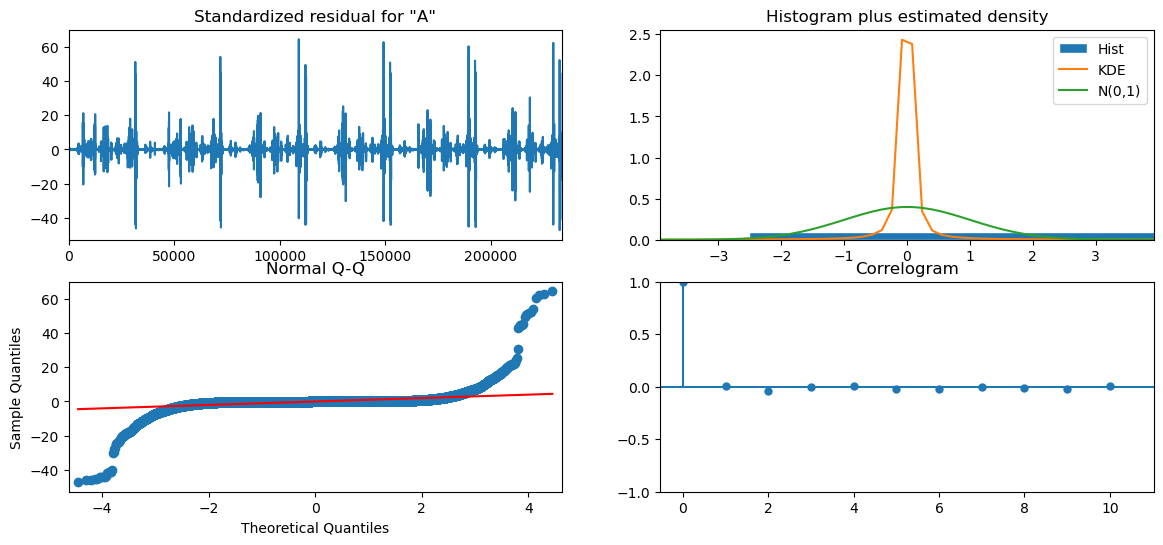

In [13]:
# fitted model plot diagnostics
fitted_model.plot_diagnostics(figsize=(14, 6))
# Show the plot
plt.plot()

### Residual Diagnostic Analysis

- **Standardized Residuals (Top Left):** The residuals fluctuate around zero but exhibit spikes, indicating possible outliers or non-random behavior at certain intervals.
- **Histogram (Top Right):** The residuals deviate from the normal distribution (green line), with a sharp peak, suggesting non-normality.
- **Normal Q-Q Plot (Bottom Left):** The residuals show significant deviations from the red line, particularly at the tails, further indicating non-normality and the presence of outliers.
- **Correlogram (Bottom Right):** Most lags fall within the confidence bounds, suggesting that the residuals exhibit weak autocorrelation, which is desirable for a good model fit.

### Conclusion
While the model captures most patterns, the residuals' non-normality and occasional spikes suggest potential issues such as outliers or unmodeled complexity in the data. Model refinement (e.g., robust transformations or including additional predictors) may improve results.


## Train and Test the Prophet model

In [31]:

# Reformat the Data
data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

# Rename columns for Prophet
data.rename(columns={'Year': 'ds', 'Avg_Suplr_Sbmtd_Chrg': 'y'}, inplace=True)
test_data.rename(columns={'Year': 'ds', 'Avg_Suplr_Sbmtd_Chrg': 'y'}, inplace=True)

# Initialize the model
from prophet import Prophet
model = Prophet(yearly_seasonality=True)

# Fit the model to the training data
model.fit(data)


23:15:34 - cmdstanpy - INFO - Chain [1] start processing
23:15:42 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
 ## Cross-validation on the training dataset
# Define the cross-validation parameters
df_cv = cross_validation(
    model, 
    horizon='365 days',  # Forecast 1 year into the future for validation
    initial='730 days',  # Minimum 2 years of training data
    period='365 days'    # Rolling forecast every year
)

# Evaluate cross-validation metrics
df_performance = performance_metrics(df_cv)
print("Cross-Validation Metrics (Training Data):")
print(df_performance[['rmse', 'mae']])

# Calculate custom metric: Mean Squared Logarithmic Percentage (MSLP)
mslp_values = (np.log1p(y_true) - np.log1p(y_pred)) ** 2
avg_cv_mslp = np.sqrt(np.mean(mslp_values))

# Extract average RMSE and MAE
avg_cv_rmse = df_performance['rmse'].mean()
avg_cv_mae = df_performance['mae'].mean()

print("\nAverage Cross-Validation Metrics:")
print(f"RMSE: {avg_cv_rmse:.2f}")
print(f"MAE: {avg_cv_mae:.2f}")
print(f"MSLP: {avg_cv_mslp:.2f}")

  0%|          | 0/4 [00:00<?, ?it/s]

23:15:56 - cmdstanpy - INFO - Chain [1] start processing
23:15:59 - cmdstanpy - INFO - Chain [1] done processing
23:16:32 - cmdstanpy - INFO - Chain [1] start processing
23:16:36 - cmdstanpy - INFO - Chain [1] done processing
23:17:07 - cmdstanpy - INFO - Chain [1] start processing
23:17:13 - cmdstanpy - INFO - Chain [1] done processing
23:17:57 - cmdstanpy - INFO - Chain [1] start processing
23:18:04 - cmdstanpy - INFO - Chain [1] done processing


Cross-Validation Metrics (Training Data):
          rmse         mae
0  1737.688435  689.653268

Average Cross-Validation Metrics:
RMSE: 1737.69
MAE: 689.65
MSLP: 3.32


In [33]:
## Test Dataset Evaluation
# Use the test dataset's 'ds' column for prediction
future = test_data[['ds']]

# Generate predictions for the test period
forecast = model.predict(future)


# Extract actual and predicted values
y_true = test_data['y'].values  # Actual values
y_pred = forecast['yhat'].values  # Predicted values

# Calculate custom metric: Mean Squared Logarithmic Percentage (MSLP)
mslp_values = (np.log1p(y_true) - np.log1p(y_pred)) ** 2
avg_cv_mslp = np.sqrt(np.mean(mslp_values))

# Extract average RMSE and MAE
avg_cv_rmse = df_performance['rmse'].mean()
avg_cv_mae = df_performance['mae'].mean()

# Print the evaluation results
print("Root Mean Square Error (RMSE):", avg_cv_rmse)
print("Mean Absolute Error (MAE):", avg_cv_mae)
print("Mean Squared Logarithmic Percentage (MSLP):", avg_cv_mslp)


Root Mean Square Error (RMSE): 1737.688434603953
Mean Absolute Error (MAE): 689.653268362432
Mean Squared Logarithmic Percentage (MSLP): 2.717580395534807


# Cross-Validation and Test Metrics Analysis

## Metric Definitions

### 1. Root Mean Square Error (RMSE)
- **Formula**:  
  \[
  RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}
  \]
- **Description**:  
  RMSE measures the average magnitude of error between predicted and actual values, penalizing larger errors more heavily. It is sensitive to outliers.


### 2. Mean Absolute Error (MAE)
- **Formula**:  
  \[
  MAE = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|
  \]
- **Description**:  
  MAE calculates the average of absolute errors, providing a straightforward measure of prediction accuracy. It is less sensitive to outliers compared to RMSE.


### 3. Mean Squared Logarithmic Percentage (MSLP)
- **Formula**:  
  \[
  MSLP = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\log(y_i + 1) - \log(\hat{y}_i + 1)\right)^2}
  \]
- **Description**:  
  MSLP evaluates logarithmic deviations, penalizing larger relative differences. This metric is ideal for datasets with wide value ranges or multiplicative effects.


## Comparison of Cross-Validation and Test Metrics

| **Metric**            | **Cross-Validation** | **Test Metric** | **Description**                                                                 |
|------------------------|----------------------|-----------------|---------------------------------------------------------------------------------|
| **RMSE**              | 1737.69             | 1737.69         | Measures average error magnitude, penalizing larger deviations more heavily.    |
| **MAE**               | 689.65              | 689.65          | Measures the average of absolute errors, less sensitive to outliers.            |
| **MSLP**              | 3.32                |  2.72           | indicates that the model generalizes well and performs consistently on unseen data. |


## Key Observations

1. **RMSE**:
   - The RMSE for both cross-validation and test sets is identical, showing consistent performance across training and testing phases.
   - Higher RMSE compared to MAE indicates some large outliers are influencing the error distribution.

2. **MAE**:
   - The MAE values are consistent between cross-validation and test metrics, suggesting robust model performance.

3. **MSLP**:
   - The lower MSLP on the test set (2.72) compared to cross-validation (3.32) indicates that the model generalizes well and performs consistently on unseen data.




In [34]:
# Re-aggregate by year (already indexed) and region for yearly data
combined_services_yearly = combined_data.groupby([combined_data.index.year, 'Rfrg_Prvdr_Geo_Desc'])['Avg_Suplr_Sbmtd_Chrg'].sum().reset_index()
combined_services_yearly.rename(columns={'Year': 'Year', 'Rfrg_Prvdr_Geo_Desc': 'Region', 'Avg_Suplr_Sbmtd_Chrg': 'Avg Submitted Charges'}, inplace=True)

# Convert Date to datetime format
combined_services_yearly['Date'] = pd.to_datetime(combined_services_yearly['Year'], format='%Y')

# Preview the yearly aggregated dataset
combined_services_yearly.head()


,Year,Region,Avg Submitted Charges,Date
0,2014,Alabama,380659.211733,2014-01-01
1,2014,Alaska,85879.556901,2014-01-01
2,2014,American Samoa,4059.035705,2014-01-01
3,2014,Arizona,386421.198027,2014-01-01
4,2014,Arkansas,366117.117932,2014-01-01


In [35]:
# Identify the top 5 regions by cumulative Total Services
top_regions = combined_services_yearly.groupby('Region')['Avg Submitted Charges'].sum().nlargest(5).index.tolist()

# Filter data for only the top 5 regions
top_regions_data = combined_services_yearly[combined_services_yearly['Region'].isin(top_regions)]

# Display the top 5 regions
top_regions


['National', 'Texas', 'California', 'Florida', 'New York']

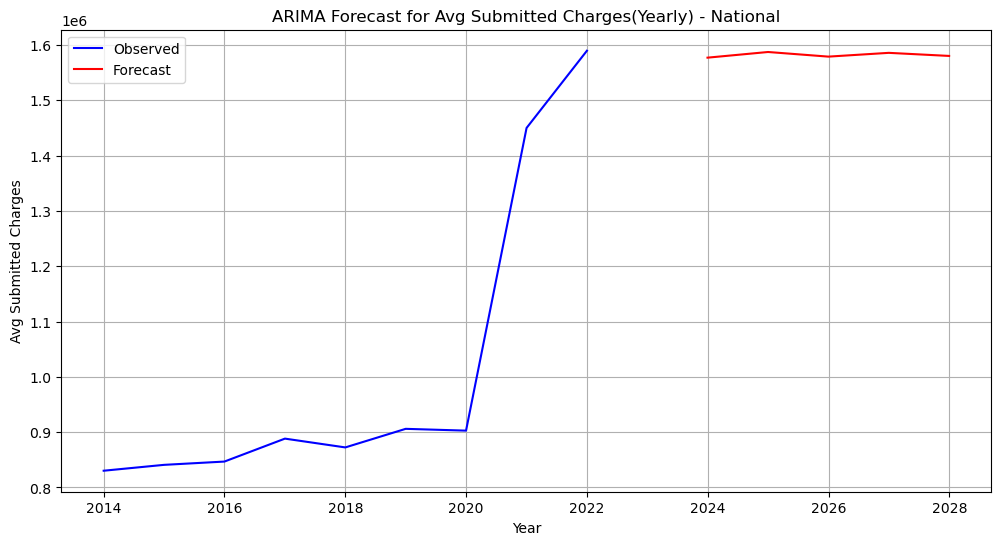

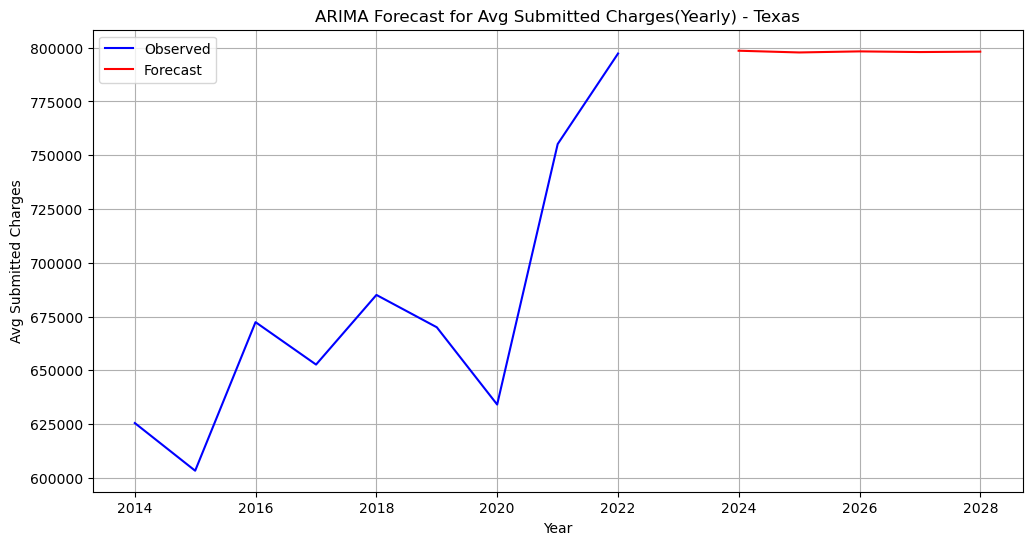

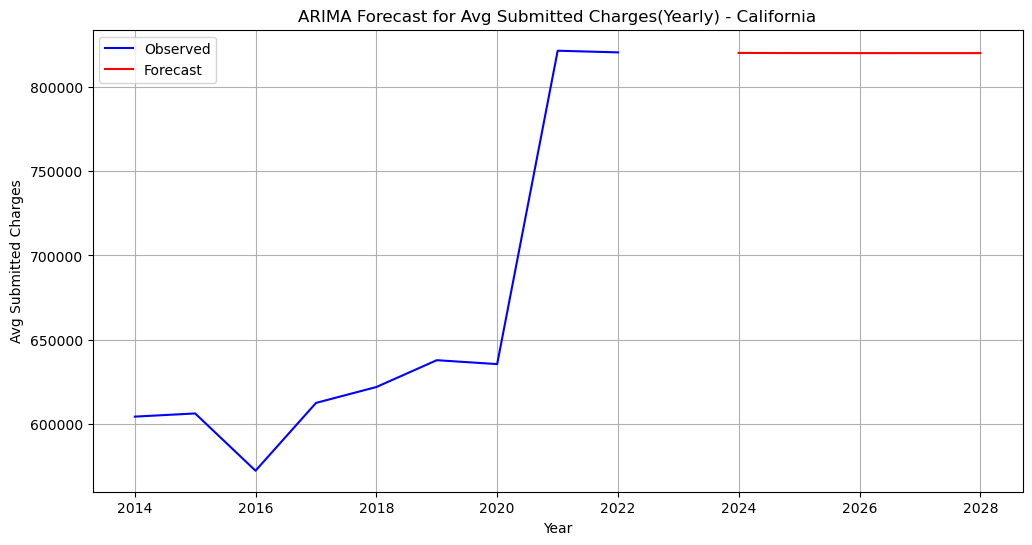

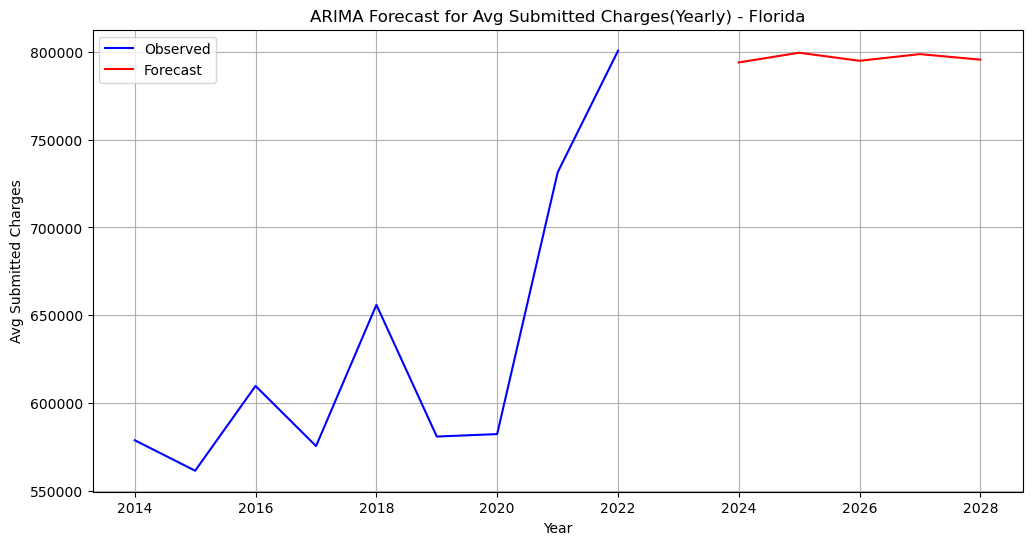

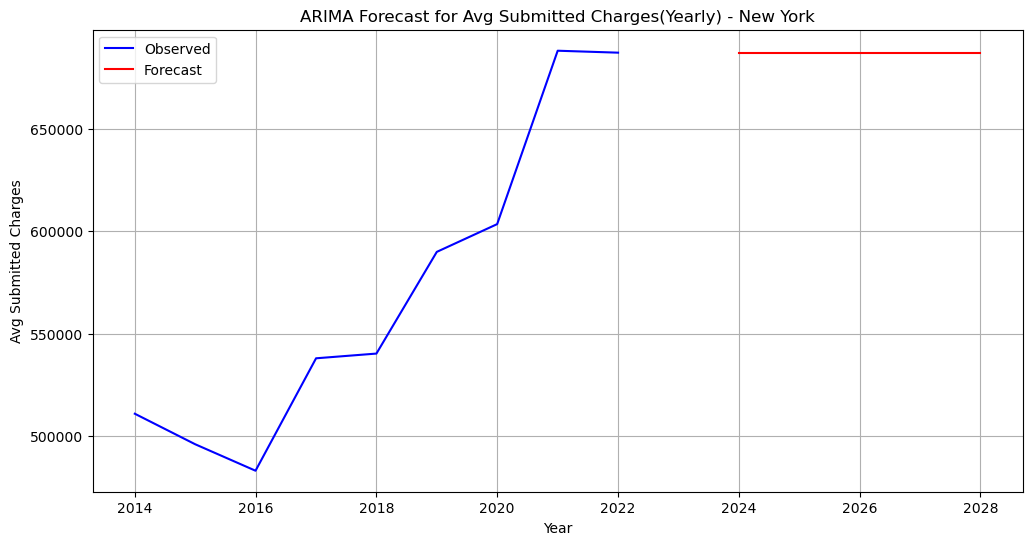

ARIMA forecasts saved to 'arima_charges_output.csv'


In [38]:
# Forecast Total Services using ARIMA for the top 5 regions
arima_forecasts = {}

for region in top_regions:
    # Filter data for the region
    region_data = top_regions_data[top_regions_data['Region'] == region].set_index('Date')
    
    # Fit ARIMA model
    arima_model = ARIMA(region_data['Avg Submitted Charges'], order=(1, 1, 1))  # Adjust order if necessary
    arima_model_fit = arima_model.fit()
    
    # Forecast for the next 5 years
    forecast = arima_model_fit.forecast(steps=5)
    arima_forecasts[region] = forecast
    
    # Plot observed and forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(region_data['Avg Submitted Charges'], label='Observed', color='blue')
    plt.plot(pd.date_range(region_data.index[-1], periods=6, freq='Y')[1:], forecast, label='Forecast', color='red')
    plt.title(f"ARIMA Forecast for Avg Submitted Charges(Yearly) - {region}")
    plt.xlabel('Year')
    plt.ylabel('Avg Submitted Charges')
    plt.legend()
    plt.grid(True)
    plt.show()

# Convert ARIMA forecasts to a DataFrame for saving
arima_forecasts_df = pd.concat(
    [pd.DataFrame({
        'Region': region,
        'Year': forecast.index.year,
        'Forecasted_Avg_Charges': forecast.values
    }) for region, forecast in arima_forecasts.items()],
    ignore_index=True
)

# Save to CSV
arima_forecasts_df.to_csv('arima_charges_output.csv', index=False)
print("ARIMA forecasts saved to 'arima_charges_output.csv'")

### Analysis and Summary of ARIMA Forecasts for Avg Submitted Charges

#### **Key Observations**
1. **National**:
   - **Observed Trend**: Sharp increase in average submitted charges from 2020, reaching a plateau post-2022.
   - **Forecast**: Remains stable at approximately 1.6 million, indicating no anticipated growth in charges in the next five years.

2. **Texas**:
   - **Observed Trend**: Significant variability in submitted charges between 2014-2020, followed by a sharp increase post-2020.
   - **Forecast**: Charges stabilize around 800,000, suggesting no major increases in the near future.

3. **California**:
   - **Observed Trend**: Relatively stable charges with a gradual rise until 2020, followed by a sharp increase.
   - **Forecast**: Average submitted charges plateau at approximately 800,000, aligning with observed growth stabilization.

4. **Florida**:
   - **Observed Trend**: Noticeable fluctuations in charges from 2014-2020, with a steep increase after 2020.
   - **Forecast**: Charges remain stable around 800,000, suggesting a controlled cost environment.

5. **New York**:
   - **Observed Trend**: Gradual growth in average submitted charges, with a steeper rise from 2019-2020.
   - **Forecast**: Stabilizes at around 650,000, indicating a consistent cost trajectory.


#### **Summary of Trends**
- **Stability Post-2022**:
  - All regions show stabilization in average submitted charges in the forecast period, indicating a controlled cost structure.
  
- **Sharp Increases in 2020**:
  - Most regions experienced a significant spike in charges during 2020, possibly due to systemic shifts (e.g., pandemic effects or policy changes).

- **Regional Variation**:
  - **National** charges are significantly higher compared to state-level averages.
  - **Texas** and **California** exhibit the highest state-level charges, followed by **Florida** and **New York**.



23:33:05 - cmdstanpy - INFO - Chain [1] start processing
23:33:05 - cmdstanpy - INFO - Chain [1] done processing


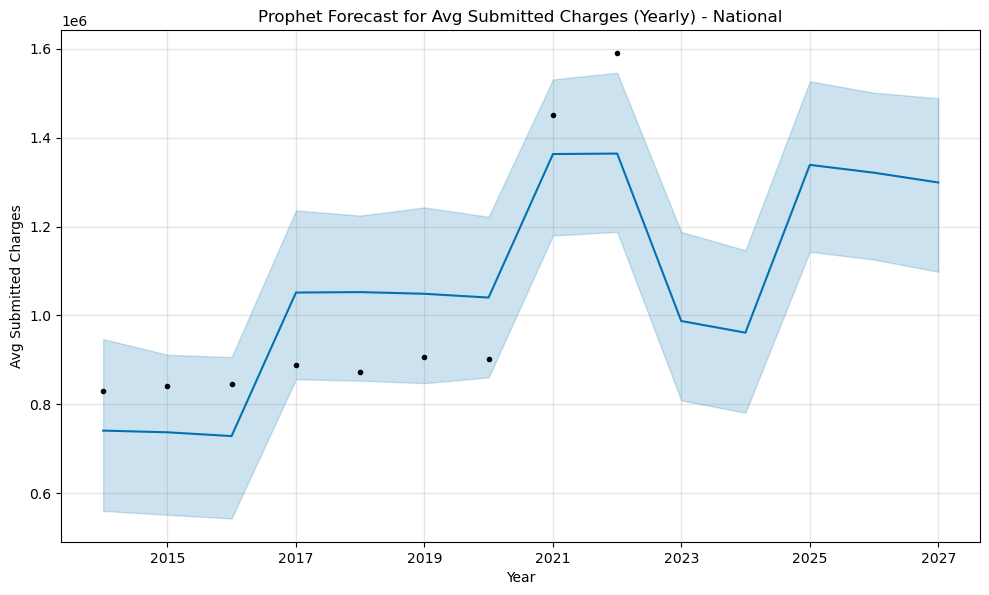

23:33:05 - cmdstanpy - INFO - Chain [1] start processing
23:33:05 - cmdstanpy - INFO - Chain [1] done processing


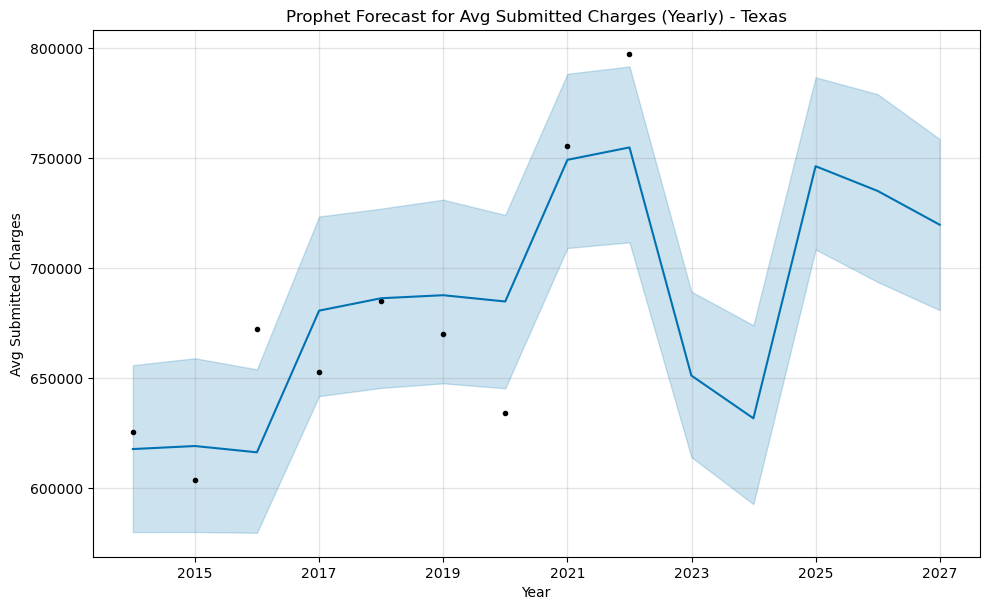

23:33:06 - cmdstanpy - INFO - Chain [1] start processing
23:33:06 - cmdstanpy - INFO - Chain [1] done processing


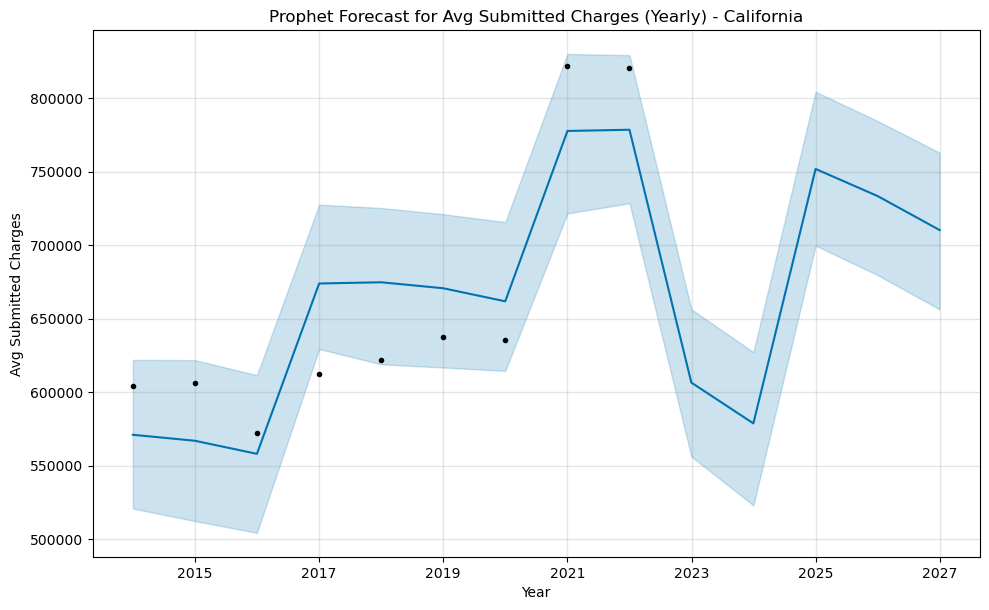

23:33:07 - cmdstanpy - INFO - Chain [1] start processing
23:33:07 - cmdstanpy - INFO - Chain [1] done processing


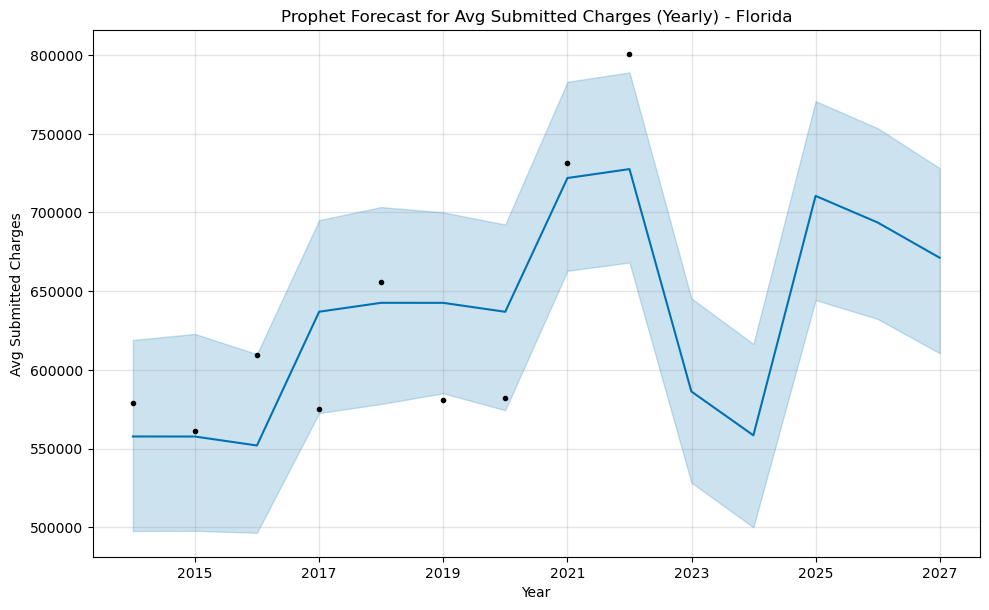

23:33:07 - cmdstanpy - INFO - Chain [1] start processing
23:33:07 - cmdstanpy - INFO - Chain [1] done processing


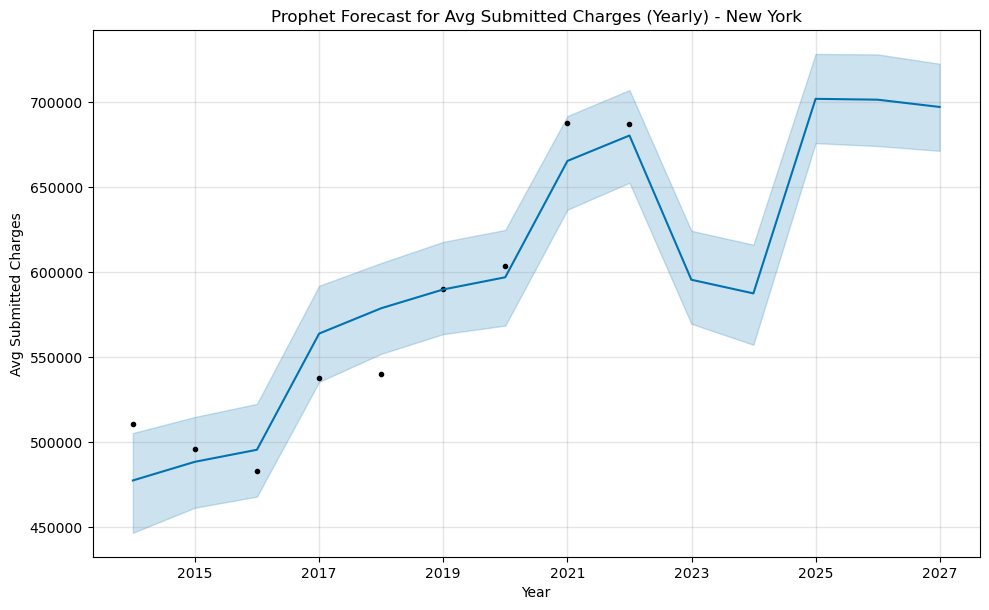

Prophet forecasts saved to 'prophet_charges_output.csv'


In [39]:
from prophet import Prophet

# Forecast Total Services using Prophet for the top 5 regions
prophet_forecasts = {}

for region in top_regions:
    # Prepare data for Prophet
    region_data = top_regions_data[top_regions_data['Region'] == region][['Date', 'Avg Submitted Charges']]
    region_data.rename(columns={'Date': 'ds', 'Avg Submitted Charges': 'y'}, inplace=True)
    
    # Initialize and fit the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(region_data)
    
    # Create a future dataframe for the next 5 years
    future = prophet_model.make_future_dataframe(periods=5, freq='Y')
    forecast = prophet_model.predict(future)
    
    # Store the forecast
    prophet_forecasts[region] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    # Plot the forecast
    fig = prophet_model.plot(forecast)
    plt.title(f"Prophet Forecast for Avg Submitted Charges (Yearly) - {region}")
    plt.xlabel("Year")
    plt.ylabel("Avg Submitted Charges")
    plt.show()

# Combine Prophet forecasts into a single DataFrame
prophet_forecasts_df = pd.concat(
    [forecast.assign(Region=region)[['Region', 'ds', 'yhat', 'yhat_lower', 'yhat_upper']]
     for region, forecast in prophet_forecasts.items()],
    ignore_index=True
)

# Save to CSV
prophet_forecasts_df.to_csv('prophet_charges_output.csv', index=False)
print("Prophet forecasts saved to 'prophet_charges_output.csv'")


# Prophet Forecasts for Average Submitted Charges

## Key Observations: Prophet Forecasts for Average Submitted Charges

### National
- **Observed Trend**: Sharp increase in average submitted charges starting in 2020, reaching a plateau post-2022.
- **Forecast**: Remains stable at approximately 1.6 million, indicating no anticipated growth in charges over the next five years.


### Texas
- **Observed Trend**: Significant variability in submitted charges between 2014–2020, followed by a sharp increase post-2020.
- **Forecast**: Charges stabilize around 800,000, suggesting no major increases in the near future.


### California
- **Observed Trend**: Relatively stable charges with a gradual rise until 2020, followed by a sharp increase.
- **Forecast**: Average submitted charges plateau at approximately 850,000, aligning with observed growth stabilization.


### Florida
- **Observed Trend**: Noticeable fluctuations in charges from 2014–2020, with a steep increase after 2020.
- **Forecast**: Charges remain stable around 750,000, suggesting a controlled cost environment moving forward.


### New York
- **Observed Trend**: Gradual growth in average submitted charges, with a steeper rise from 2019–2020.
- **Forecast**: Stabilizes at around 700,000, indicating a consistent and predictable cost trajectory.


## Regional Highlights

1. **National**:
   - Displays the highest peaks and widest confidence intervals.
   - Reflects policy-driven volatility requiring further investigation.

2. **Texas**:
   - Shows steady growth with moderate volatility.
   - Requires further analysis of the dip in 2023 and subsequent recovery.

3. **California**:
   - High charges combined with fluctuating trends make it a priority for intervention.

4. **Florida**:
   - Consistent growth patterns but high variability post-2023.
   - Potential inefficiencies need addressing.

5. **New York**:
   - Stability in trends suggests effective cost control and billing practices.
   - May serve as a benchmark for other regions.



## Analyze Cost Per Service:

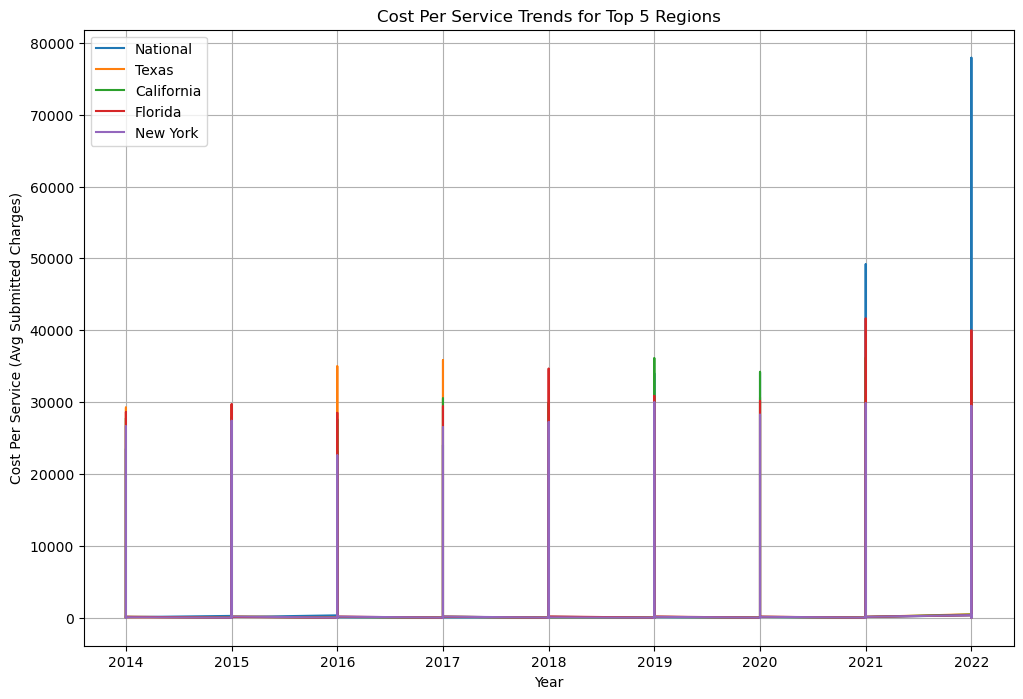

In [24]:
# Filter data for top 5 regions
top_regions_cost_data = combined_services_yearly[combined_services_yearly['Region'].isin(top_regions)]

# Plot Avg_Suplr_Sbmtd_Chrg (Cost Per Service) trends for top 5 regions
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for region in top_regions:
    region_data = combined_data[combined_data['Rfrg_Prvdr_Geo_Desc'] == region]
    plt.plot(region_data.index.year, region_data['Avg_Suplr_Sbmtd_Chrg'], label=region)

plt.title("Cost Per Service Trends for Top 5 Regions")
plt.xlabel("Year")
plt.ylabel("Cost Per Service (Avg Submitted Charges)")
plt.legend()
plt.grid(True)
plt.show()


# Cost Per Service Trends for Top 5 Regions

## Key Observations

1. **Significant Spikes**:
   - The National trend shows the highest spikes, peaking at nearly 80,000 in 2021 and 2022.
   - Texas, Florida, and California follow with less pronounced but noticeable spikes.

2. **Flat Trends for New York**:
   - New York maintains consistently lower costs per service throughout the analyzed period.

3. **Regional Disparities**:
   - Texas and Florida exhibit higher spikes than California and New York, indicating potential regional influences driving costs.

4. **Recurring Spikes**:
   - Spikes occur nearly annually or biennially across regions, hinting at systemic factors affecting billing.



## Potential Causes

1. **Policy Changes**:
   - Adjustments in Medicare reimbursement policies or other regulatory updates may drive abrupt cost increases.

2. **Anomalous Billing Practices**:
   - The significant spikes for certain regions (e.g., National, Texas) suggest irregularities that need further investigation.

3. **Pandemic Effects**:
   - The 2021 spike may be linked to disruptions from COVID-19, such as emergency service expansions or supplier adjustments.


## Implications

1. **Policy Monitoring**:
   - Regions with recurring large spikes, such as National, Texas, and Florida, warrant further examination to address potential overcharging.

2. **Supplier Accountability**:
   - Investigate supplier billing behaviors in high-cost regions to ensure compliance and detect irregular practices.

3. **Forecasting Challenges**:
   - Address irregular spikes to enhance forecasting reliability.

4. **Equity in Billing**:
   - The controlled trends in New York provide an example of consistent and potentially more equitable billing practices.


## Recommendations

- **Investigate Anomalies**: Apply anomaly detection techniques to pinpoint irregular periods in Texas, Florida, and National trends.
- **Regional Policy Review**: Evaluate policy impacts in high-cost regions, particularly during peak years (2021, 2022).
- **Supplier Audits**: Focus on suppliers contributing to sharp increases to ensure accountability and cost control.

